In [1]:

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

fake['label'] = 0
true['label'] = 1

data = pd.concat([fake[['text', 'label']], true[['text', 'label']]])
data = data.sample(frac=1).reset_index(drop=True)  # shuffle
data.head()


,text,label
0,KABUL (Reuters) - A blast in the Afghan capita...,1
1,Instead of respectfully attending President Ob...,0
2,Donald Trump is causing mass chaos within the ...,0
3,BERLIN (Reuters) - Germany s conservative chan...,1
4,The GOP didn t panic when a poll conducted ear...,0


In [3]:
def clean_text(text):
    text = re.sub(r'\W', ' ', text)         # Remove non-word characters
    text = text.lower()                     # Lowercase
    text = re.sub(r'\s+', ' ', text)        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['text'] = data['text'].apply(clean_text)


In [4]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['text']).toarray()
y = data['label'].values


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [6]:
model = tf.keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\ROG\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │         500,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500,201 (1.91 MB)

 Trainable params: 500,201 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9277 - loss: 0.3173 - val_accuracy: 0.9825 - val_loss: 0.0634
Epoch 2/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9899 - loss: 0.0425 - val_accuracy: 0.9872 - val_loss: 0.0426
Epoch 3/3
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9965 - loss: 0.0201 - val_accuracy: 0.9896 - val_loss: 0.0369


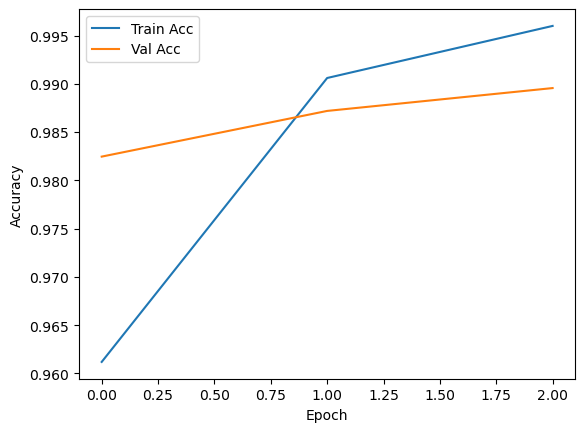

In [8]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
def predict_news(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned]).toarray()
    pred = model.predict(vec)[0][0]
    return "REAL" if pred >= 0.5 else "FAKE"



In [10]:
print(predict_news("The president is Donald Trump"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
REAL


In [11]:
print(predict_news("India Pakistan war happened in 2025."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
FAKE


In [12]:
print(predict_news("The president declares economic reforms to boost growth."))
print(predict_news("NASA has confirmed aliens landed in London."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
FAKE


In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9891 - loss: 0.0341
Test Accuracy: 99.04%
